# Generative Adverserial Imitation Learning

Generative Adversarial Imitation Learning (GAIL) was first proposed in the paper [Generative Adversarial Imitation Learning](https://arxiv.org/abs/1606.03476) by Jonathan Ho and Stefano Ermon. The project task is to implement the Generative Adverserial Imitation Learning model for driving scenarios using the bark-simulator.

GAIL is based on the setting of Reinforcement Learning (RL). In Reinforcment Learning, the agent interacts with the environment through its actions and receives rewards in return. The aim of the learning process is to maximize to cummulative reward by chosing the right action in the states.

As the name suggests, GAIL falls into a smaller subgroup of RL, called Imitation Learning. In this setup the goal of the agent is to mimik an expert behavior as closely as possible. The environment awards higher rewards to expert-like behavior and smaller to actions which deviate from the expert behavior much. In our case, expert trajectories were generated from real life data, namely from the interaction dataset, as well as from a pretrained SAC (Soft Actor-Critic) agent. The expert trajectories, which are gained in this way represent the expert knowladge by containing many states and the corresponding actions which were produced by the expert.

A said, the learning of the agent in the RL setting is driven by the rewards it receives from the environmen. The amount of the reward in the Imitation Learning case are determined based on how closely the agent mimics the expert behavior. Furthermore, specially in the GAIL approach we get the reward from an adversarial game: The agent is represented by the generator network, which is trained based on the feedback of the discriminator network. The generator produces actions for given states, which are then judged by the discriminator. In the meantime the discriminator is trained by feeding it expert and agent state-action pairs for classification. In this way the generator tries to fool the discriminator, hence tries to act as expert-like as possible, meanwhile the discriminator tries to identify expert and agent trajectories from eachother. Intuitively the learning converges, when the generator learned to act so similarly to the expert that the discriminator can not tell apart expert and agent trajectories any more. In game theory this point is called the Nash-equilibrium.

In practice, the implementation of a GAIL agent is usually solved in the following way for sample efficiency: The agent interacts with the environment by following its actual policy and hence agent state-action pairs are generated. These points are stored in a replay buffer for further learning. After a specified interval a training step is carried out. This training step has got 2 substeps: training the discriminator and training the generator networks. 
* __Discriminator training:__ The discriminator is fed a batch of expert (from the expert trajectories) and agent (from the replay buffer) state-action pairs. It classifies all of them. Based on their true labels the loss is calculated and a gradient descent step is carried out in order to minimize the loss.
* __Generator training:__ The generator is fed a batch of states from the replay buffer and it produces actions for them. The resulting state-action pairs are fed to the discriminator for classification. The negative output of the discriminator is used as a loss for the generator network. (Close to -1 if the agent mimics the expert successfully.) The gradient of the loss is propagated all the way back to the generator network to carry out a gradient step for minimizing the it.
As said, the training goes until both the generator and the discriminator loss converge to a stady state value. The training process is visualized in the following figure:


<img width=70% src="files/data/gail_overview.gif">

## Interaction Dataset
As a data source, we used the interaction dataset: https://arxiv.org/abs/1910.03088. Here, we are interested in the merging scenarios: deu_merging_mt and chn_merging_zs. Have a look how the Interaction Dataset is integrated in bark: https://github.com/bark-simulator/bark/blob/setup_tutorials/docs/tutorials/04_interaction_dataset.ipynb (Note that the dataset itself is NOT enclosed with bark due to license limitations).

## Expert Trajectories
As said, we have generated expert trajectories using the Interaction Dataset and also a trained SAC agent. The Interaction Dataset of course contains logs about many different vehicles with different wheel bases. To remedy this issue, we have used a fixed wheel base when calculating the actions from the successive states. This however does not restrict the accuracy of the data, we just consider that all state trajectories were carried out by the same car and calculate the actions that car would have required to carrie out that behavior. 

As the state variables and also the actions have diferent magnitudes, we normalize all of them for training. The normalization of the expert trajectories takes place while loading the generated expert trajectories. The loading function also takes the actual environment (BARK runtime) as an input, hence the trajectories can be normalized according to the current parameters. (Current state and action spaces.)

## Generate Expert Trajectories
A short example script for generating expert trajectories from the interaction dataset are shown in the followings. 

In [1]:
import os 
import bark
from pprint import pprint
from bark_ml.library_wrappers.lib_tf2rl.generate_expert_trajectories import *

tracks_folder = os.path.join(os.getcwd(), 'data')
map_file = os.path.join(os.getcwd(), 'data/DR_DEU_Merging_MT_v01_shifted.xodr')
known_key = ('DR_DEU_Merging_MT_v01_shifted', 'vehicle_tracks_013')
ego_agent = 66

param_server = create_parameter_servers_for_scenarios(map_file, tracks_folder)[known_key]
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["TrackIds"] = [
    63, 64, 65, 66, 67, 68]
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["StartTs"] = 232000
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["EndTs"] = 259000
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]["EgoTrackId"] = ego_agent

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


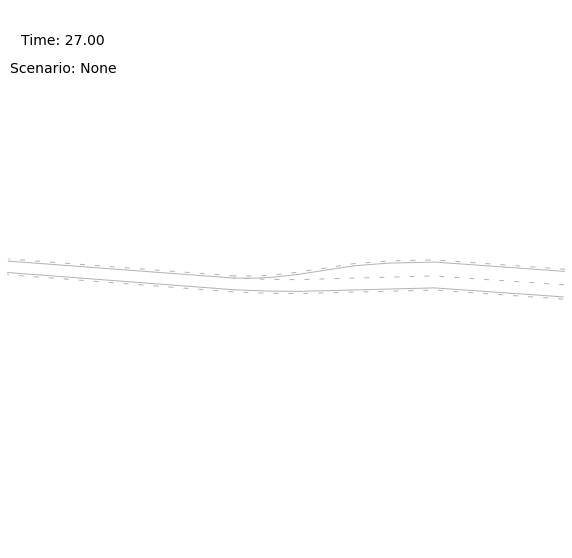

In [2]:
expert_trajectories = generate_expert_trajectories_for_scenario(param_server, sim_time_step=200, renderer="matplotlib_jupyter")

### The generated expert trajectories:
The generated expert trajectories are stored in a dictionary with keys:
* `obs`: list, containing the observation vector for the timestep.
* `act`: list, containing the action that was carried out in that timestep.
* `next_obs`: list, the next observation after carrying out the action `act` in the state `obs`. 

The following 2 cells show some example states and actions for being able to better understanding the format.

In [3]:
# Small number of observations for our agent
print(f'Observations for the agent {ego_agent}\n')
pprint(expert_trajectories[ego_agent]['obs'][:5])

Observations for the agent 66

[array([ 998.184021  , 1006.93701172,    3.08599997,    2.19539237,
        995.9619751 , 1004.27398682,    3.05999994,    1.66448367,
       1004.67498779, 1006.34100342,    3.06100011,    1.7957828 ,
       1004.05700684, 1003.58398438,    3.07299995,    1.92759383]),
 array([ 997.74597168, 1006.9619751 ,    3.08599997,    2.18845916,
        995.63201904, 1004.30102539,    3.05999994,    1.62844038,
       1004.31799316, 1006.36901855,    3.06200004,    1.77660406,
       1003.67797852, 1003.60699463,    3.07500005,    1.82607996]),
 array([ 997.30999756, 1006.98699951,    3.08500004,    2.17947364,
        995.309021  , 1004.32800293,    3.05900002,    1.59439075,
       1003.96502686, 1006.39697266,    3.06200004,    1.75758469,
       1003.31799316, 1003.62902832,    3.07599998,    1.72271013]),
 array([ 996.875     , 1007.01202393,    3.08500004,    2.16549611,
        994.99298096, 1004.35498047,    3.05900002,    1.56133819,
       1003.61499023,

In [4]:
# Small number of actions for our agent
print(f'Actions of the agent {ego_agent}\n')
pprint(expert_trajectories[ego_agent]['act'][:5])

Actions of the agent 66

[[-0.034666060884802626, 0.0],
 [-0.044927593029058605, -0.006168197873944377],
 [-0.06988764225766911, 0.0],
 [-0.09983778594957507, -0.006233605047211027],
 [-0.1200890254762112, 0.0]]


## GAIL implementation

### TF2RL implementation
We have chosen an off the shelf implementation, the library [TF2RL](https://github.com/keiohta/tf2rl). It implements several reinforcement algorithms and training methods in [tensorflow 2](https://www.tensorflow.org/guide/effective_tf2). 

The GAIL agent is built up as follows:
* __Generator:__ A complete DDPG agent with the actor and critic networks. Both of them has 2-2 hidden layers.
* __Discriminator:__ A normal discriminator network with 2 hidden layers.

In this respect the agent is not in the traditional GAIL setup with 2 neural networks, but instead it actually has 5 networks, since the DDPG agent it self has got 4 of them for greater stability during training. The DDPG agent's critic network basically receives the judgement of the Discriminator network as the reward from the environment and its training aims to maximize this reward.

### Integration into BARK
The integration of the TF2RL based GAIL agent is done along existing BARK concepts and has been done in the following most important classes:
* __TF2RLWrapper:__ Wraps the BARK runtime to match the expectations of tf2rl about the environment. The observation and action normalization also takes place here.
    * source: `bark_ml/library_wrappers/lib_tf2rl/tf2rl_wrapper.py`
* __BehaviorTF2RLAgent:__ Base class for TF2RL based agents.
    * source: `bark_ml/library_wrappers/lib_tf2rl/agents/tf2rl_agent.py`
* __BehaviorGAILAgent:__ The TF2RL based GAIL agent.
    * source: `bark_ml/library_wrappers/lib_tf2rl/agents/gail_agent.py`
* __TF2RLRunner:__ Base class for TF2RL based runners.
    * source: `bark_ml/library_wrappers/lib_tf2rl/runners/tf2rl_runner.py`
* __GAILRunner:__ The TF2RL based GAIL runner.
    * source: `bark_ml/library_wrappers/lib_tf2rl/runners/gail_runner.py`
    
In the followings the training process is shown. Later the performance of a pre-trained agent can be visualized.

---

### Training
The parameters which can be set on demand:
* The number of steps to train for.
* The frequency of testing during training
* The number of episodes in each testing round.

In [5]:
# Costumise some parameters here!!! #

max_steps = 100000          # Number of steps to train for.
test_interval = 1000        # test in every ... steps.
test_episodes = 5           # number of test episodes.
gpu = 0                     # use -1 for cpu only.

In [6]:
# IMPORTS
import os
from pathlib import Path

# BARK imports
from bark_project.bark.runtime.commons.parameters import ParameterServer
from bark.runtime.viewer.matplotlib_viewer import MPViewer
from bark.runtime.viewer.video_renderer import VideoRenderer

# BARK-ML imports
from bark_ml.environments.blueprints import ContinuousHighwayBlueprint, \
  ContinuousMergingBlueprint, ContinuousIntersectionBlueprint, GailMergingBlueprint
from bark_ml.environments.single_agent_runtime import SingleAgentRuntime
from bark_ml.library_wrappers.lib_tf2rl.tf2rl_wrapper import TF2RLWrapper
from bark_ml.library_wrappers.lib_tf2rl.agents.gail_agent import BehaviorGAILAgent
from bark_ml.library_wrappers.lib_tf2rl.runners.gail_runner import GAILRunner
from bark_ml.library_wrappers.lib_tf2rl.load_expert_trajectories import load_expert_trajectories

# Load the TensorBoard notebook extension
%load_ext tensorboard

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


The next cell deletes the previous logs and launches tensorboard. After tensorboard has launced, please go on to the next cell and start the training. The tensorboard window refreshes it self in every 30 secs, but you can also refresh it by hand in the top right corner.

In [7]:
# launching tensorboard and deleting the previous runs logdirs:
%rm -r "data/logs"
%mkdir "data/logs"
%tensorboard --logdir "data/logs"

rm: cannot remove 'data/logs': No such file or directory


11:04:45.466 [INFO] (trainer.py:65) Restored None
11:04:45.608 [INFO] (irl_trainer.py:74) Total Epi:     1 Steps:       7 Episode Steps:     7 Return: -1.0000 FPS: 53.17
11:05:55.219 [INFO] (irl_trainer.py:74) Total Epi:     2 Steps:      11 Episode Steps:     4 Return: -1.0000 FPS: 521.20
11:05:55.245 [INFO] (irl_trainer.py:74) Total Epi:     3 Steps:      20 Episode Steps:     9 Return: -1.0000 FPS: 376.24
11:05:55.251 [INFO] (irl_trainer.py:74) Total Epi:     4 Steps:      22 Episode Steps:     2 Return: -1.0000 FPS: 391.63
11:05:55.265 [INFO] (irl_trainer.py:74) Total Epi:     5 Steps:      25 Episode Steps:     3 Return: -1.0000 FPS: 303.83
11:05:55.278 [INFO] (irl_trainer.py:74) Total Epi:     6 Steps:      28 Episode Steps:     3 Return: -1.0000 FPS: 285.29
11:05:55.294 [INFO] (irl_trainer.py:74) Total Epi:     7 Steps:      34 Episode Steps:     6 Return: -1.0000 FPS: 435.64
11:05:55.309 [INFO] (irl_trainer.py:74) Total Epi:     8 Steps:      38 Episode Steps:     4 Return: -1.

11:05:56.047 [INFO] (irl_trainer.py:74) Total Epi:    69 Steps:     413 Episode Steps:     5 Return: -1.0000 FPS: 602.44
11:05:56.066 [INFO] (irl_trainer.py:74) Total Epi:    70 Steps:     425 Episode Steps:    12 Return: -1.0000 FPS: 685.98
11:05:56.081 [INFO] (irl_trainer.py:74) Total Epi:    71 Steps:     432 Episode Steps:     7 Return: -1.0000 FPS: 540.17
11:05:56.091 [INFO] (irl_trainer.py:74) Total Epi:    72 Steps:     437 Episode Steps:     5 Return: -1.0000 FPS: 598.82
11:05:56.123 [INFO] (irl_trainer.py:74) Total Epi:    73 Steps:     459 Episode Steps:    22 Return: -1.0000 FPS: 706.36
11:05:56.135 [INFO] (irl_trainer.py:74) Total Epi:    74 Steps:     462 Episode Steps:     3 Return: -1.0000 FPS: 308.22
11:05:56.142 [INFO] (irl_trainer.py:74) Total Epi:    75 Steps:     464 Episode Steps:     2 Return: -1.0000 FPS: 384.21
11:05:56.151 [INFO] (irl_trainer.py:74) Total Epi:    76 Steps:     467 Episode Steps:     3 Return: -1.0000 FPS: 407.20
11:05:56.165 [INFO] (irl_trainer

11:05:57.052 [INFO] (irl_trainer.py:74) Total Epi:   137 Steps:     960 Episode Steps:     2 Return: -1.0000 FPS: 387.42
11:05:57.063 [INFO] (irl_trainer.py:74) Total Epi:   138 Steps:     963 Episode Steps:     3 Return: -1.0000 FPS: 290.56
11:05:57.072 [INFO] (irl_trainer.py:74) Total Epi:   139 Steps:     967 Episode Steps:     4 Return: -1.0000 FPS: 560.94
11:05:57.085 [INFO] (irl_trainer.py:74) Total Epi:   140 Steps:     972 Episode Steps:     5 Return: -1.0000 FPS: 422.63
11:05:57.101 [INFO] (irl_trainer.py:74) Total Epi:   141 Steps:     979 Episode Steps:     7 Return: -1.0000 FPS: 498.01
11:05:57.109 [INFO] (irl_trainer.py:74) Total Epi:   142 Steps:     981 Episode Steps:     2 Return: -1.0000 FPS: 385.00
11:05:57.124 [INFO] (irl_trainer.py:74) Total Epi:   143 Steps:     990 Episode Steps:     9 Return: -1.0000 FPS: 677.47
11:05:59.797 [INFO] (irl_trainer.py:119) Evaluation Total Steps:    1000 Average Reward -1.0000 / Average Step Count  16.4 over  5 episodes
11:05:59.836 

11:06:09.125 [INFO] (irl_trainer.py:74) Total Epi:   205 Steps:    1577 Episode Steps:    20 Return: -1.0000 FPS: 63.73
11:06:09.339 [INFO] (irl_trainer.py:74) Total Epi:   206 Steps:    1590 Episode Steps:    13 Return: -1.0000 FPS: 61.23
11:06:09.566 [INFO] (irl_trainer.py:74) Total Epi:   207 Steps:    1604 Episode Steps:    14 Return: -1.0000 FPS: 62.00
11:06:09.670 [INFO] (irl_trainer.py:74) Total Epi:   208 Steps:    1610 Episode Steps:     6 Return: -1.0000 FPS: 58.84
11:06:09.829 [INFO] (irl_trainer.py:74) Total Epi:   209 Steps:    1620 Episode Steps:    10 Return: -1.0000 FPS: 63.46
11:06:10.065 [INFO] (irl_trainer.py:74) Total Epi:   210 Steps:    1635 Episode Steps:    15 Return: -1.0000 FPS: 64.09
11:06:10.333 [INFO] (irl_trainer.py:74) Total Epi:   211 Steps:    1651 Episode Steps:    16 Return: -1.0000 FPS: 60.06
11:06:10.496 [INFO] (irl_trainer.py:74) Total Epi:   212 Steps:    1661 Episode Steps:    10 Return: -1.0000 FPS: 61.84
11:06:10.591 [INFO] (irl_trainer.py:74) 

11:06:22.412 [INFO] (irl_trainer.py:74) Total Epi:   273 Steps:    2341 Episode Steps:    11 Return: -1.0000 FPS: 60.55
11:06:22.608 [INFO] (irl_trainer.py:74) Total Epi:   274 Steps:    2353 Episode Steps:    12 Return: -1.0000 FPS: 61.78
11:06:22.718 [INFO] (irl_trainer.py:74) Total Epi:   275 Steps:    2359 Episode Steps:     6 Return: -1.0000 FPS: 55.04
11:06:22.933 [INFO] (irl_trainer.py:74) Total Epi:   276 Steps:    2372 Episode Steps:    13 Return: -1.0000 FPS: 61.10
11:06:23.102 [INFO] (irl_trainer.py:74) Total Epi:   277 Steps:    2382 Episode Steps:    10 Return: -1.0000 FPS: 59.66
11:06:23.344 [INFO] (irl_trainer.py:74) Total Epi:   278 Steps:    2392 Episode Steps:    10 Return: -1.0000 FPS: 41.69
11:06:23.513 [INFO] (irl_trainer.py:74) Total Epi:   279 Steps:    2399 Episode Steps:     7 Return: -1.0000 FPS: 41.89
11:06:23.833 [INFO] (irl_trainer.py:74) Total Epi:   280 Steps:    2413 Episode Steps:    14 Return: -1.0000 FPS: 44.04
11:06:24.068 [INFO] (irl_trainer.py:74) 

11:06:35.051 [INFO] (irl_trainer.py:74) Total Epi:   341 Steps:    3001 Episode Steps:     2 Return: -1.0000 FPS: 12.58
11:06:35.258 [INFO] (irl_trainer.py:74) Total Epi:   342 Steps:    3011 Episode Steps:    10 Return: -1.0000 FPS: 48.80
11:06:35.383 [INFO] (irl_trainer.py:74) Total Epi:   343 Steps:    3018 Episode Steps:     7 Return: -1.0000 FPS: 56.89
11:06:35.582 [INFO] (irl_trainer.py:74) Total Epi:   344 Steps:    3030 Episode Steps:    12 Return: -1.0000 FPS: 60.77
11:06:35.699 [INFO] (irl_trainer.py:74) Total Epi:   345 Steps:    3037 Episode Steps:     7 Return: -1.0000 FPS: 60.46
11:06:35.768 [INFO] (irl_trainer.py:74) Total Epi:   346 Steps:    3041 Episode Steps:     4 Return: -1.0000 FPS: 60.05
11:06:36.074 [INFO] (irl_trainer.py:74) Total Epi:   347 Steps:    3060 Episode Steps:    19 Return: -1.0000 FPS: 62.37
11:06:36.243 [INFO] (irl_trainer.py:74) Total Epi:   348 Steps:    3069 Episode Steps:     9 Return: -1.0000 FPS: 53.65
11:06:36.470 [INFO] (irl_trainer.py:74) 

11:06:45.358 [INFO] (irl_trainer.py:74) Total Epi:   410 Steps:    3593 Episode Steps:    13 Return: -1.0000 FPS: 61.56
11:06:45.572 [INFO] (irl_trainer.py:74) Total Epi:   411 Steps:    3606 Episode Steps:    13 Return: -1.0000 FPS: 61.27
11:06:45.686 [INFO] (irl_trainer.py:74) Total Epi:   412 Steps:    3613 Episode Steps:     7 Return: -1.0000 FPS: 61.98
11:06:45.741 [INFO] (irl_trainer.py:74) Total Epi:   413 Steps:    3616 Episode Steps:     3 Return: -1.0000 FPS: 56.82
11:06:45.823 [INFO] (irl_trainer.py:74) Total Epi:   414 Steps:    3621 Episode Steps:     5 Return: -1.0000 FPS: 61.49
11:06:45.902 [INFO] (irl_trainer.py:74) Total Epi:   415 Steps:    3626 Episode Steps:     5 Return: -1.0000 FPS: 65.13
11:06:46.015 [INFO] (irl_trainer.py:74) Total Epi:   416 Steps:    3633 Episode Steps:     7 Return: -1.0000 FPS: 62.53
11:06:46.084 [INFO] (irl_trainer.py:74) Total Epi:   417 Steps:    3637 Episode Steps:     4 Return: -1.0000 FPS: 59.61
11:06:46.167 [INFO] (irl_trainer.py:74) 

11:06:54.180 [INFO] (irl_trainer.py:74) Total Epi:   478 Steps:    4127 Episode Steps:     5 Return: -1.0000 FPS: 60.47
11:06:54.366 [INFO] (irl_trainer.py:74) Total Epi:   479 Steps:    4139 Episode Steps:    12 Return: -1.0000 FPS: 64.88
11:06:54.432 [INFO] (irl_trainer.py:74) Total Epi:   480 Steps:    4143 Episode Steps:     4 Return: -1.0000 FPS: 61.78
11:06:54.512 [INFO] (irl_trainer.py:74) Total Epi:   481 Steps:    4148 Episode Steps:     5 Return: -1.0000 FPS: 63.58
11:06:54.646 [INFO] (irl_trainer.py:74) Total Epi:   482 Steps:    4156 Episode Steps:     8 Return: -1.0000 FPS: 60.35
11:06:54.743 [INFO] (irl_trainer.py:74) Total Epi:   483 Steps:    4162 Episode Steps:     6 Return: -1.0000 FPS: 63.14
11:06:54.809 [INFO] (irl_trainer.py:74) Total Epi:   484 Steps:    4166 Episode Steps:     4 Return: -1.0000 FPS: 62.13
11:06:54.894 [INFO] (irl_trainer.py:74) Total Epi:   485 Steps:    4171 Episode Steps:     5 Return: -1.0000 FPS: 59.40
11:06:54.960 [INFO] (irl_trainer.py:74) 

11:07:03.944 [INFO] (irl_trainer.py:74) Total Epi:   547 Steps:    4736 Episode Steps:    11 Return: -1.0000 FPS: 63.79
11:07:04.174 [INFO] (irl_trainer.py:74) Total Epi:   548 Steps:    4751 Episode Steps:    15 Return: -1.0000 FPS: 65.61
11:07:04.272 [INFO] (irl_trainer.py:74) Total Epi:   549 Steps:    4757 Episode Steps:     6 Return: -1.0000 FPS: 61.90
11:07:04.460 [INFO] (irl_trainer.py:74) Total Epi:   550 Steps:    4765 Episode Steps:     8 Return: -1.0000 FPS: 42.79
11:07:04.680 [INFO] (irl_trainer.py:74) Total Epi:   551 Steps:    4774 Episode Steps:     9 Return:  1.0000 FPS: 41.30
11:07:04.929 [INFO] (irl_trainer.py:74) Total Epi:   552 Steps:    4787 Episode Steps:    13 Return: -1.0000 FPS: 52.72
11:07:05.129 [INFO] (irl_trainer.py:74) Total Epi:   553 Steps:    4796 Episode Steps:     9 Return:  1.0000 FPS: 46.11
11:07:05.360 [INFO] (irl_trainer.py:74) Total Epi:   554 Steps:    4811 Episode Steps:    15 Return: -1.0000 FPS: 65.06
11:07:05.488 [INFO] (irl_trainer.py:74) 

KeyboardInterrupt: 

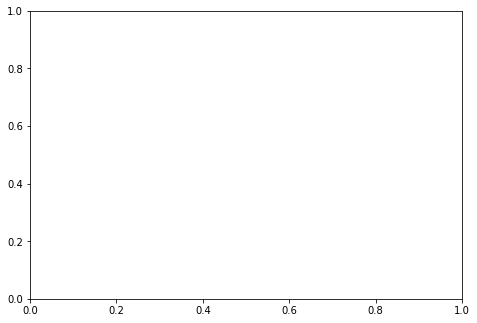

In [9]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
params["ML"]["GAILRunner"]["tf2rl"]["max_steps"] = max_steps
params["ML"]["GAILRunner"]["tf2rl"]["test_interval"] = test_interval
params["ML"]["GAILRunner"]["tf2rl"]["test_episodes"] = test_episodes
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create some logging dirs if they are not present already
Path(params["ML"]["GAILRunner"]["tf2rl"]["logdir"]).mkdir(exist_ok=True, parents=True)
Path(params["ML"]["GAILRunner"]["tf2rl"]["model_dir"]).mkdir(exist_ok=True, parents=True)

# create environment
bp = ContinuousMergingBlueprint(params,
                              number_of_senarios=500,
                              random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                      render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                           params=params)

# load the expert trajectories
expert_trajectories, _, _ = load_expert_trajectories(
    params["ML"]["GAILRunner"]["tf2rl"]["expert_path_dir"],
    normalize_features=params["ML"]["Settings"]["NormalizeFeatures"],
    env=env # the unwrapped env has to be used, since that contains the unnormalized spaces.
    ) 

# instantiate a runner that is going to train the agent.
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,
                 expert_trajs=expert_trajectories)

# train the agent
runner.Train()

### Trained agent visualization:
Please set up the number of scenarios to visualize in the next cell!

In [10]:
# Number of scenarios to visualize:
num_scenarios_to_visualize = 10

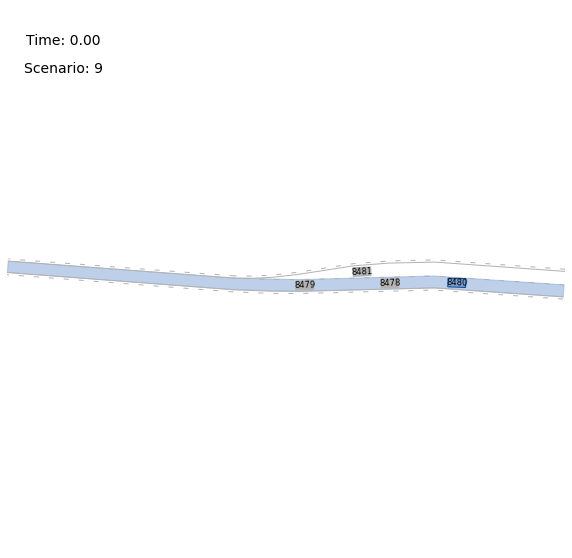

In [12]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# setting the path for the pretrained agent.
params["ML"]["GAILRunner"]["tf2rl"]["model_dir"] = os.path.join('data', 'pretrained_agent')

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
params["ML"]["GAILRunner"]["tf2rl"]["max_steps"] = max_steps
params["ML"]["GAILRunner"]["tf2rl"]["test_interval"] = test_interval
params["ML"]["GAILRunner"]["tf2rl"]["test_episodes"] = test_episodes
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create some logging dirs if they are not present already
Path(params["ML"]["GAILRunner"]["tf2rl"]["logdir"]).mkdir(exist_ok=True, parents=True)
Path(params["ML"]["GAILRunner"]["tf2rl"]["model_dir"]).mkdir(exist_ok=True, parents=True)

# create environment
bp = ContinuousMergingBlueprint(params,
                              number_of_senarios=500,
                              random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                      render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                           params=params)

# load the expert trajectories
expert_trajectories, _, _ = load_expert_trajectories(
    params["ML"]["GAILRunner"]["tf2rl"]["expert_path_dir"],
    normalize_features=params["ML"]["Settings"]["NormalizeFeatures"],
    env=env # the unwrapped env has to be used, since that contains the unnormalized spaces.
    ) 

# instantiate a runner that is going to train the agent.
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,
                 expert_trajs=expert_trajectories)

# Visualize the agent
runner.Visualize(num_scenarios_to_visualize, renderer="matplotlib_jupyter")